In [ ]:
#| default_exp codenotes

# Code Notes
> Pipeline for annotating code cells with notes

Code notes operate by annotation notes in an exploratory fashion. It involves a simple two step process:

1. Write the code you want to annotate in a code cell:

```python
def addition(a,b):
    "Adds two numbers together"
    return a+b
```

> Note: In this example it is a function, but this could be any code whatsoever. Variable definitions, quick oneliners in Jupyter, it does not matter!

2. In subsequant cells, include an explaination for each line while following the following template:

```
explain {{code to highlight}} {{instance number of code occuring}}

This is my explanation
```

For example, I could have:

```
explain a+b

We take the sum of a and b, which is written in python with the "+" symbol
```

Or, if the code you wish to explain is multiple lines, you can select between which code to highlight such as:

```
explain multiline (a,b) 0 return a+b 0

This function takes the two inputs (a and b) and returns their sum
```

The zeros in these tags (`0`) are **instance numbers** for these parts. So if code is repeated in the block group, you can specify which particular subset the note belongs to.

These then get rendered together later as notes when calling `build_notes` from the CLI, and can be viewed on the documentation website. 

These notes are rendered as a two-block column, with the first showing just the code, and the second showing the code and snippets below it with each explanation.

See an example now:

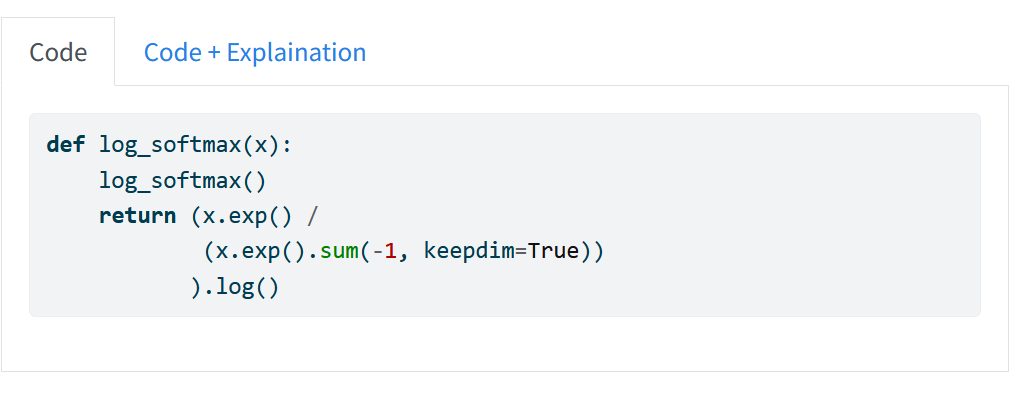

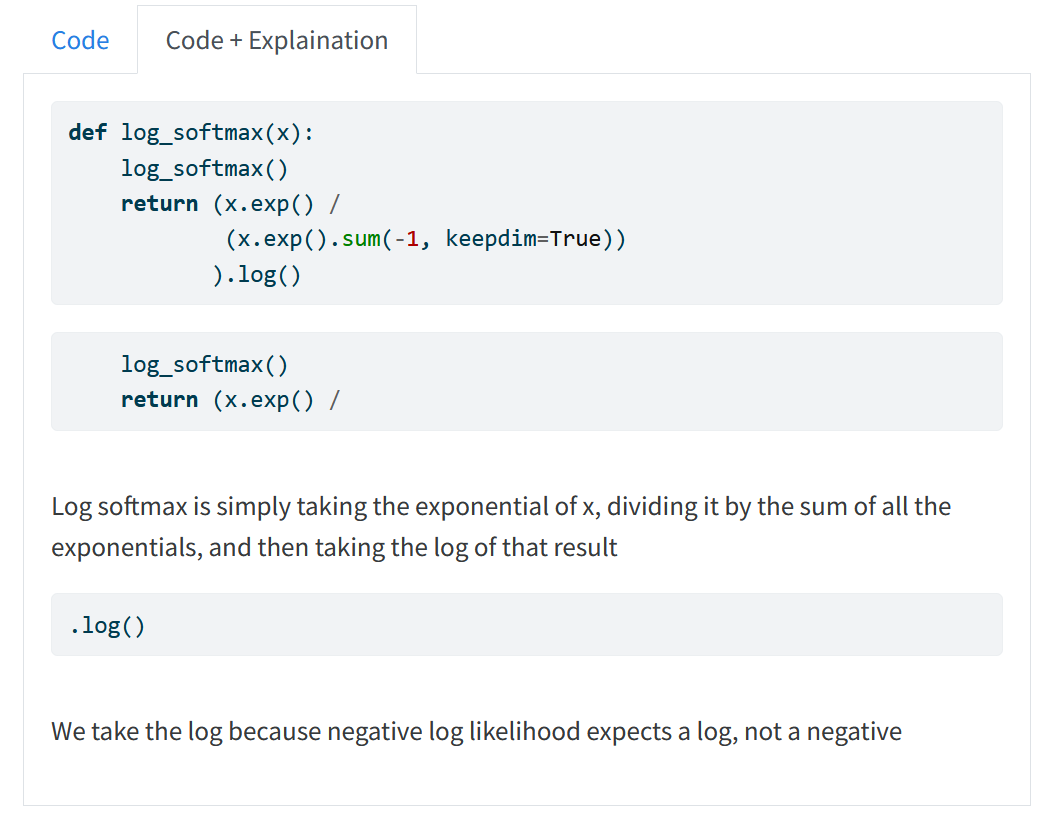

In [ ]:
#| export
from nbdev.config import get_config
from nbdev.process import NBProcessor, extract_directives
from nbdev.processors import Processor, mk_cell
from nbdev.export import nb_export
from nbdev.doclinks import nbglob
from nbdev.sync import write_nb

from fastcore.script import call_parse
from fastcore.xtras import Path

import shlex
import re

In [ ]:
#| export
def make_panel_tabset():
    "Creates a templated panel tabset for Quarto"
    cells = [
        mk_cell("::: {.panel-tabset}\n\n## Code", cell_type="markdown"),
        # Original goes here
        mk_cell("## Code + Explanation", cell_type="markdown"),
        # All explainations go here
        mk_cell(":::", cell_type="markdown")
    ]
    return cells

In [ ]:
#| export
def convert_explanation(explanation_cell, source):
    "Takes an explanation and source code and linkes them together in a new cell"
    _py, newline = "{.python}", "\n"
    explanation = re.sub(r'\*#|.*[\n]', "", explanation_cell.source)
    content = f"```{_py}{newline}{source}{newline}```"
    content += f"{newline}{explanation}"
    return mk_cell(content, cell_type="markdown")

In [ ]:
#| export
def extract_code(start_code, end_code, source, instance_num, end_instance_num=0):
    "Finds code between start and finish potentially with instances to check"
    start_match = list(re.finditer(f'[ \t]*{start_code}', source))[int(instance_num)]
    start_char = start_match.span()[0]
    end_match = list(re.finditer(f'[ \t]*{end_code}', source))[int(end_instance_num)]
    end_char = end_match.span()[1]
    return source[start_char:end_char]

In [ ]:
#| export
def parse_code(code_cell, markdown_cell):
    "Parses directives to extract the code needed to be highlighted"
    directives = markdown_cell.directives_["explain"]
    directives = shlex.split(" ".join(directives))
    multiline = "multiline" in directives
    if multiline:
        directives = directives[1:]
        if len(directives) == 4:
            start_code, start_instance_num, end_code, end_instance_num = directives
        else:
            (start_code, start_instance_num, end_code), (end_instance_num) = directives, 0
        start_code, end_code = re.escape(start_code), re.escape(end_code)
        return extract_code(start_code, end_code, code_cell.source, start_instance_num, end_instance_num)
    else:
        return directives[0]

In [ ]:
#| export
class NoteExportProc(Processor):
    "A proc that checks and reorganizes cells for documentation for proper explainations"
    offset = 0
    steps = []
    _i = 0
    def begin(self):
        self.reset()
        self.has_reset = False
        self.iter = 0
        self.offset = 0
    
    def reset(self):
        self.results = make_panel_tabset()     
        self.code = []
        self._code = None
        self.found_explanation = False
        self.end_link = False
        self.explanations = []
        self.start_idx = None
        self.end_idx = None
    
    def cell(self, cell):
        if cell.cell_type == "code":
            if not self.found_explanation:
                self._code = cell
                self.start_idx = cell.idx_
                
        if cell.cell_type == "markdown" and "explain" in cell.directives_:
            self.found_explanation = True
            self.explanations.append(cell)
            
        if self.found_explanation:
            idx = cell.idx_ + 1
            if (len(self.nb.cells) <= idx+1) or ("explain" not in self.nb.cells[idx].directives_):
                self.end_link = True
                self.end_idx = cell.idx_ + 1
        
        if self.found_explanation and self.end_link:
            # Assume we have all code + explainations
            tabset_code_idx = 1
            tabset_explain_idx = 3
            self.results.insert(tabset_code_idx, self._code)
            explanations = []
            for i,explanation in enumerate(self.explanations):
                source = parse_code(self._code, explanation)
                converted_explanation = convert_explanation(explanation, source)
                explanations.append(converted_explanation)
                self.nb.cells.remove(explanation)
            self.results = self.results[:3] + explanations + [self.results[3]]
            self.nb.cells.remove(self._code)
            self.offset = 0
            for result in self.results:
                result.idx_ = self.nb.cells[self.start_idx - 1].idx_ + 1
                # print(f'Front: {self.nb.cells[self.start_idx].source}\nInserting: {result.source}')
                self.nb.cells.insert(self.start_idx + self.offset, result)
                # print(self.nb.cells[self.start_idx + self.offset].source)
                self.offset += 1
            self.iter += 1
            # self.nb_copy.cells[self.start_idx+1:self.end_idx] = self.results
            self.reset()
            self.has_reset = True
            
            self.offset = 0
            for i,c in enumerate(self.nb.cells): c.idx_ = i

In [ ]:
processor = NBProcessor(nb_path, [NoteExportProc], rm_directives=False)
processor.process()

In [ ]:
with open("test.ipynb", "w") as text_file:
    text_file.write(nb2str(processor.nb))

In [ ]:
#| export
@call_parse
def parse_notes():
    "Exports notebooks to parsed notes for documentation. Should be called in the workflow, not yourself!"
    for nb in nbglob(get_config().nbs_path):
        processor = NBProcessor(nb, [NoteExportProc], rm_directives=False)
        processor.process()
        write_nb(processor.nb, nb)

To use this, copy the [deploy.yaml](https://github.com/muellerzr/nbdev-extensions/blob/main/.github/workflows/deploy.yaml) from this repo and use it in your own nbdev repository

Now it will automatically build your docs like notes!

In [ ]:
def addition(a,b):
    "Adds two numbers together"
    return a+b

#| explain a+b

We return the sum of `a` and `b`

#| explain return a+b

Return something

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()